In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034_Yellow_Taxi_Preprocessing_Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 17:35:34 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.27.239.27 instead (on interface eth0)
22/08/22 17:35:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/22 17:35:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/22 17:35:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/22 17:35:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# read in feature engineered and collated 2019 taxi data & confirm
sdf_filtered = spark.read.parquet('../data/curated/yt2019_cleaned.parquet')
#sdf.show(1, vertical=True, truncate=100)

In [3]:
sdf_filtered.count()

71742914

### Taking a look at fare_per_minute (fpm)

In [4]:
sdf_filtered.describe('fare_per_minute').show()

+-------+-------------------+
|summary|    fare_per_minute|
+-------+-------------------+
|  count|           71742914|
|   mean| 0.9329056250925222|
| stddev|0.24203635337567123|
|    min|0.05341355599214146|
|    max| 38.990697674418605|
+-------+-------------------+



In [5]:
avg_fpm_weekday = sdf_filtered.groupBy('PU_dayofweek').agg(
    {
        'fare_per_minute' : 'mean',
    }
).toPandas()

In [6]:
import seaborn as sns
from pyspark.sql import functions as F

/home/noahs/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:xlabel='PU_dayofweek', ylabel='avg(fare_per_minute)'>

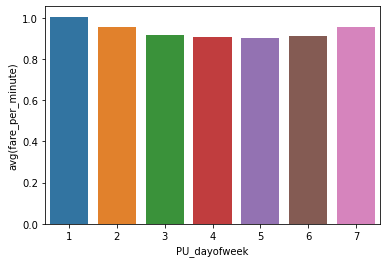

In [7]:
sns.barplot(x=avg_fpm_weekday['PU_dayofweek'], y=avg_fpm_weekday['avg(fare_per_minute)'])

In [8]:
sdf_filtered.select('fare_per_minute').sort(F.desc('fare_per_minute')).show()

+------------------+
|   fare_per_minute|
+------------------+
|38.990697674418605|
|27.783251231527093|
| 25.57377049180328|
| 25.54945054945055|
|24.566929133858267|
|24.152542372881356|
| 23.11111111111111|
|21.224489795918366|
| 20.93959731543624|
|20.662251655629138|
|  20.3921568627451|
|              20.0|
|19.872611464968152|
|19.024390243902438|
| 18.24561403508772|
|             16.25|
|15.757575757575758|
|15.294117647058824|
|14.854455445544554|
| 14.11764705882353|
+------------------+
only showing top 20 rows



### Bivariate Analysis

In [9]:
# subsample from the filtered and clean data ->
sdf_samp = sdf_filtered.sample(fraction=0.001, seed=0)
sdf_samp.count()

71402

Fare amount by year

In [32]:
# https://www.kaggle.com/code/nicapotato/taxi-rides-time-analysis-and-oof-lgbm/notebook
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(2,2, figsize = [12,6])
    #f, ax = plt.subplots(len(timeframes), figsize = [8,12])

    i = 0
    j = 0

    #for df in dfs

    for o, x in enumerate(timeframes):

        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i,j],color=color)
        ax[i,j].set_ylabel(value.replace("_", " ").title())
        ax[i,j].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i,j].set_xlabel("")

        # bit rudimentary here by me, why not use zip
        if i == 0 and j == 0:
            i = 1
            j = 0
        elif i == 1 and j == 0:
            i = 0
            j = 1

        elif i == 0 and j == 1:
            i = 1
            j = 1
    #ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)


In [29]:
df_pu_fare_by_time = sdf_samp.select(['PU_dayofmonth', 'PU_dayofweek', 'PU_hourofday', 'PU_month', 'fare_amount', 'trip_distance']).toPandas()
#df_fare_by_time = sdf_filtered.select(['PU_dayofmonth', 'PU_dayofweek', 'PU_hourofday', 'PU_month', 'fare_amount', 'trip_distance']).toPandas()
df_do_fare_by_time = sdf_samp.select(['DO_dayofmonth', 'DO_dayofweek', 'DO_hourofday', 'DO_month', 'fare_amount', 'trip_distance']).toPandas()

In [30]:
import matplotlib.pyplot as plt

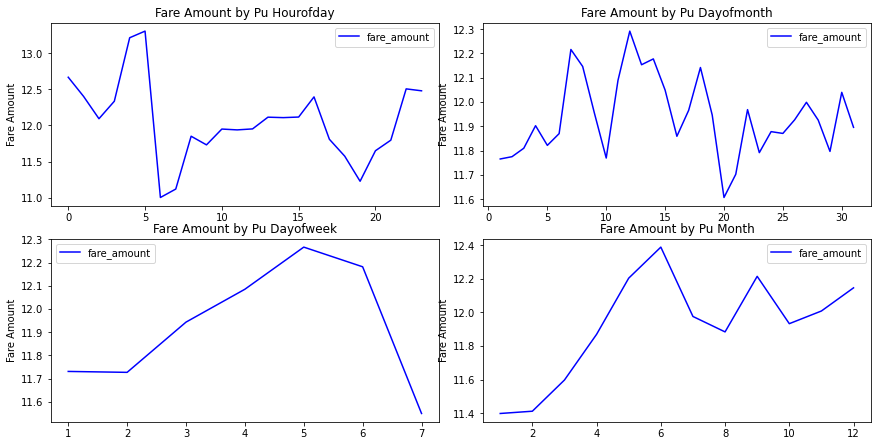

In [33]:
time_slicer(df = df_pu_fare_by_time, timeframes = ['PU_hourofday', 'PU_dayofweek', 'PU_dayofmonth', 'PU_month'], value = 'fare_amount', color="blue")

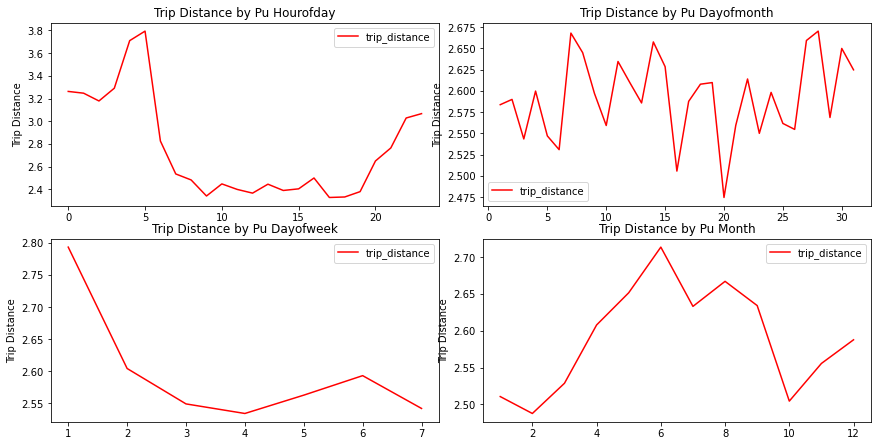

In [44]:
time_slicer(df = df_pu_fare_by_time, timeframes = ['PU_hourofday', 'PU_dayofweek', 'PU_dayofmonth', 'PU_month'], value = 'trip_distance', color="red")

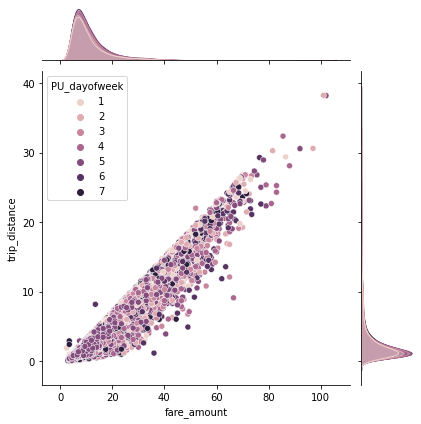

In [47]:
# more random pltos
sns.jointplot(x=df_pu_fare_by_time['fare_amount'], y=df_pu_fare_by_time['trip_distance'], hue=df_pu_fare_by_time['PU_dayofweek'])

In [48]:
spark.sql("CLEAR CACHE")
spark.stop()